* 개념정리 
* 데이터를 다양하게 분석
* 전처리하고 시각화(eda)
* 어떤 모델을 선택할 것인지 : 왜 선택했는지 시각화
* 오류 ( 오류코드, 문제점, ,해결방법) 
* 한줄정리 & 소감

# [E-13] 주식예측

# 목차

STEP 1 : 시계열 데이터 준비

STEP 2 : 각종 전처리 수행


STEP 3 : 시계열 안정성 분석

STEP 4 : 학습, 테스트 데이터셋 생성

STEP 5 : 적정 ARIMA 모수 찾기

STEP 6 : ARIMA 모델 훈련과 테스트

STEP 7 : 다른 주식 종목 예측해 보기

# 개념 이해

## 시계열 데이터
= 시간 순서대로 발생한 데이터 숫자의 나열이다. 

주식 거래의 경우 시계열 데이터의 형태는 날짜-가격 이다.
날짜가 인덱스 역할을 한다. 

100% 정확한 미래 예측은 불가능하지만 안정적인 데이터 내에서 어느정도 짐작 수준의 예측은 가능하다. 

### 안정적인 시계열 데이터란?
= 시간의 변화와 상관없이 일정한 패턴을 가진 시계열 데이터

* 특징
평균, 분산, 공분산이 시간과 관계없이 일정해야한다. 


**확률변수** = 정의되지 않은 값
한 방에 있는 사람들의 키 ( 정의되지 않은 값 ) 가 확률변수라면 그와 상관관계를 알고 싶은 몸무게도 또다른 확률변수가 된다 .

키와 몸무게가 서로에게 미치는 영향에 대해 알고 싶다 . ( 키 :x, 몸무게 :y)

**공분산(Covariance)** : 두 개 (x, y) 의 대상 간의 상관관계를 나타내는 지표 (x, y 의 관계가 선형적인가) 

즉 이전의 데이터와 지금의 데이터가 관련있는지 보기위한 것

단위의 크기에 영향을 받아서 총점이 200이면 200이라서 큰값이 나오고 20이면 20점 만점이라 작은 값이 나온다. 객관적으로 어떤 값이 큰지 알 수 없다.

 **상관계수(correlation)** : 단위까지 고려한 값
 
x,y의 단위를 일치시켜 단위의 크기에 영향을 받지 않도록 한 것

* 상관계수는 1을 넘을 수 없다.
* X,Y가 관련이 없다면 상관계수는 0이다. 
* 선형적인 관계가 있다면 상관계수는 1 or -1이다.  값이 커질 수록 상관성이 강한 것

### 시계열 데이터는 어떻게 분석할까 ?

decomposition( 시계열 데이터 분해 )
* seasonality : 주기성
* trend : 추세 ( 주기성 x)
* residual : noise

잔차 ≠ ERROR : 작동이 안되는 오류를 뜻하는것이 아니라 추세와 주기성외에 설명할 수 없는 것을 잔차라고 한다. 
크게 주기성과 주기성이 아닌 속성으로 나눌 수 있다 .

# STEP 1 : 시계열 데이터 준비

칼럼 종류: Date, Open, High, Low, Close, Adj Close, Volume
날짜별로 시작가(Open), 최고가(High), 최저가(Low), 종가(Close), 수정종가(Adj Close), 거래량(Volume)이 저장되어 있는 것을 확인할 수 있지만, 우리는 Close만 사용하겠습니다

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

In [4]:
dataset_filepath=os.getenv('HOME')+'/aiffel/aiffel_exp_data/stock_prediction/data/samsung.csv'
df= pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts=df['Close']
print(type(ts))
ts.head()

<class 'pandas.core.series.Series'>


Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64

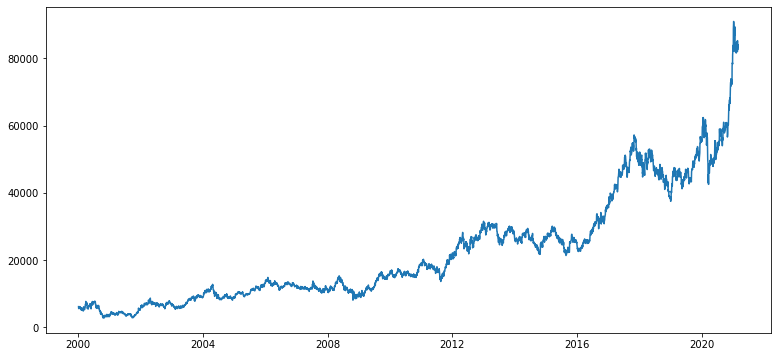

In [5]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 13, 6    #
# 시계열(time series) 데이터를 차트로 그려 봅시다. 
plt.plot(ts)

# STEP 2 : 각종 전처리 수행

In [6]:
# 결측치 처리
# 결측치 대처는 모두 삭제하거나 보간을 대입할 수 있음 
# 날짜를 index로 갖기에 보간하는 방법 선택

ts=ts.interpolate(method='time')
ts[ts.isna()]

Series([], Name: Close, dtype: float64)

# STEP 3 : 시계열 안정성 분석

= 안정적인 시계열 데이터인지 분석하는 통계적인 방법

**방법**   
* 정성적 그래프 분석(기본)
* 정량적 Augmented Dicky-Fuller Test
* 시계열 분해(Time Series Decomposition)
* Residual 안정성 확인

### 1. 정성적 그래프 분석: 구간 통계치

In [7]:
#구간 통계치 시각화
# 현재시간부터 window에 주어진 시간 이전 구간의 평균과 표준편차를 원본이랑 시각화해본다.

def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
print('슝=3')

슝=3


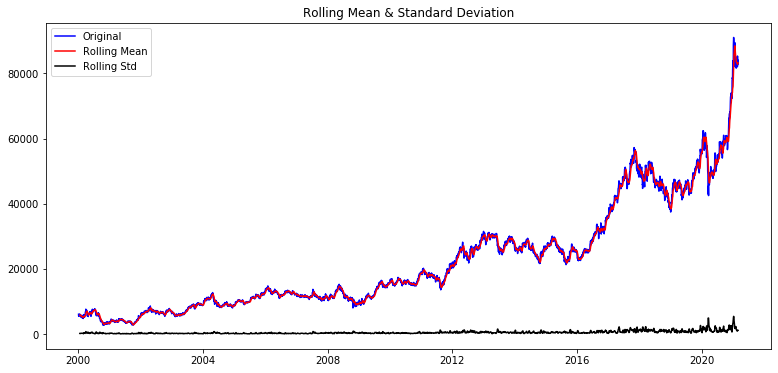

In [8]:
plot_rolling_statistics(ts, window=12)

시간에 따라 평균과 분산이 증가하는 패턴을 보이면 데이터가 안정적이지 않은 것!

불안정한 시계열 데이터는 어떻게 분석해야하는가?

## 2. 정량적 그래프 분석: ADF Test(Augmented Dickey-Fuller Test)

##   ADF?
= 귀무가설을 세운 후, 통계적인 가설검정 과정을 통해서 귀무가설이 사실이 아님이 밝혀지면 시계열 데이터가 안정적이라는 새로운 대립가설을 채택함

* 귀무가설: 시계열 데이터가 안정적이지 않다고 생각함

## 가설 검정의 개념

**p-value**: 귀무가설(시계열 데이터가 불안정하다)이 틀렸다고 볼 수 있는 확률

* 값이 0.05미만으로 낮게 나오면 p-value만큼의 오류가 발생할 수 있다고 생각하고 귀무가설을 기각함(시계열 데이터가 불안정하다는 것을 취소함)-> 대립가설을 채택하는 근거가 됨!

대립가설(귀무가설의 반대):시계열 데이터는 안정적이다. 

### statesmodels 패키지
= R에서 제공하는 통계검정, 시계열 분석 기능을 가진 통계패키지

이 패키지에서 제공하는 adfuller메소드로 timeseries에 대한 정량적 분석을 진행한다. 


참고:https://blog.naver.com/PostView.nhn?blogId=yk60park&logNo=221909260519&parentCategoryNo=&categoryNo=281&viewDate=&isShowPopularPosts=false&from=postView

In [9]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # adfuller 메소드를 호출합니다.
    df_test = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    df_output = pd.Series(df_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in df_test[4].items():
        df_output['Critical Value (%s)' % key] = value
    print(df_output)
    
print('adf 함수 정의')

adf 함수 정의


In [10]:
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                    2.431916
p-value                           0.999025
#Lags Used                       26.000000
Number of Observations Used    5293.000000
Critical Value (1%)              -3.431586
Critical Value (5%)              -2.862086
Critical Value (10%)             -2.567061
dtype: float64


p-value 값이  0.99가 나왔다. 귀무가설을 기각할 수 없음

결론: 시계열 데이터는 불안정하다 

## 불안정한 시계열 데이터는 어떻게 해야할까?

= 안정적인 시계열로 바꿔야한다.

**방법**
1. 정성적인 분석으로 안정적인 특성을 갖도록 기존 데이터를 변형한다.
2. 시계열 분해 기법 적용

### 정성적인 분석

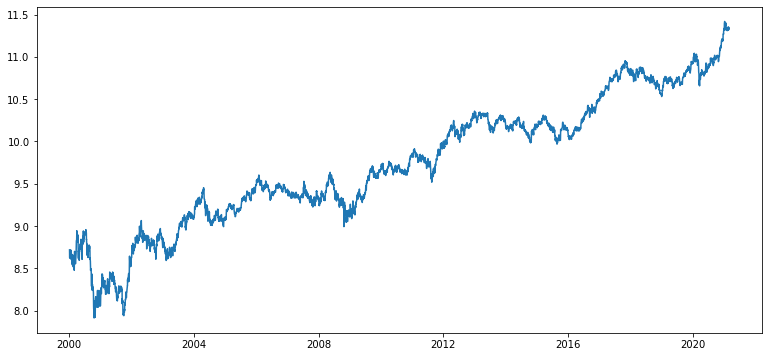

In [11]:
# 로그함수 변환: 시계열이 시간이 지나면서 점점 분산이 커질때 로그변환으로 안정적으로 만듬

ts_log = np.log(ts)
plt.plot(ts_log)

In [12]:
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.300283
p-value                           0.925464
#Lags Used                        4.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


로그 변환으로 p-value값이 0.08 줄어들었다. 

시계열 분석에서 시간의 변화에 따른 평균값 변화를 추세(trend)라고 한다.
시간에 영향을 받지 않으려면 이 변화를 제거해야 한다 -> moving average 하기

rolling mean(평균값 변화)를 구하고 로그변환 한 값에서 빼기

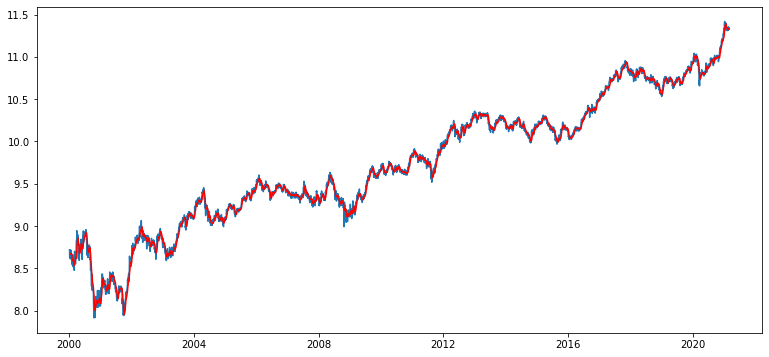

In [13]:
moving_avg = ts_log.rolling(window=12).mean() 
plt.plot(ts_log)
plt.plot(moving_avg, color='red')

In [14]:
ts_log_moving_avg = ts_log - moving_avg # 변화량 제거
ts_log_moving_avg.head(15)

Date
2000-01-04         NaN
2000-01-05         NaN
2000-01-06         NaN
2000-01-07         NaN
2000-01-10         NaN
2000-01-11         NaN
2000-01-12         NaN
2000-01-13         NaN
2000-01-14         NaN
2000-01-17         NaN
2000-01-18         NaN
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007850
2000-01-24   -0.024419
Name: Close, dtype: float64

In [15]:
# windows size 가 12라서 앞에 11개의 데이터는 계산되지 않음
# 결측치는 에러를 유발함으로 제거한다.

ts_log_moving_avg.dropna(inplace=True)
ts_log_moving_avg.head(15)

Date
2000-01-19    0.024767
2000-01-20    0.039061
2000-01-21    0.007850
2000-01-24   -0.024419
2000-01-25   -0.069588
2000-01-26   -0.057965
2000-01-27   -0.047001
2000-01-28    0.004477
2000-01-31   -0.035715
2000-02-01   -0.075802
2000-02-02   -0.076542
2000-02-03   -0.085232
2000-02-04   -0.072735
2000-02-07   -0.039679
2000-02-08    0.002573
Name: Close, dtype: float64

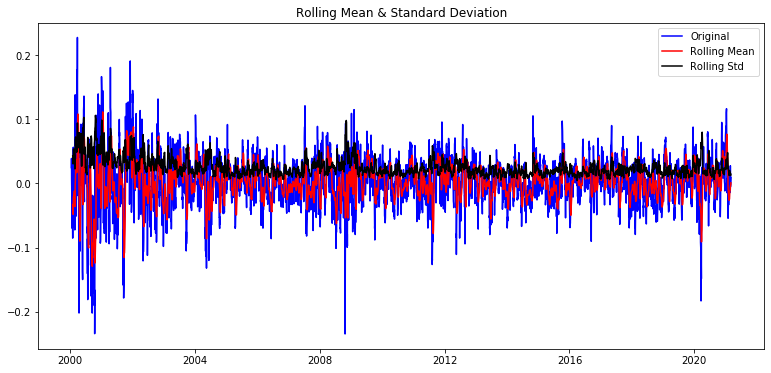

In [16]:
plot_rolling_statistics(ts_log_moving_avg)

In [17]:
augmented_dickey_fuller_test(ts_log_moving_avg)

Results of Dickey-Fuller Test:
Test Statistic                -1.665164e+01
p-value                        1.602158e-29
#Lags Used                     1.100000e+01
Number of Observations Used    5.297000e+03
Critical Value (1%)           -3.431585e+00
Critical Value (5%)           -2.862086e+00
Critical Value (10%)          -2.567061e+00
dtype: float64


값이 1을 넘는다...더 불안정한 값이 나옴 

시계열 데이터는 추세와 주기성을 갖고 있음

추세는 moving average 제거로 해결할 수 있지만, 주기성은 differencing(차분)을 사용해서 제거해야함!

* differencing은 해당 시계열-직전 시계열 하는 것! 

이를 통해 직전 시계열 데이터 대비 얼만큼 변화했는지 알 수 있다.

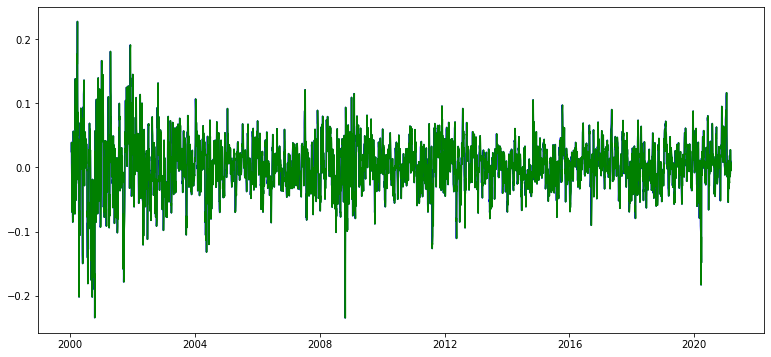

In [18]:
ts_log_moving_avg_shift = ts_log_moving_avg.shift()

plt.plot(ts_log_moving_avg, color='blue')
plt.plot(ts_log_moving_avg_shift, color='green')

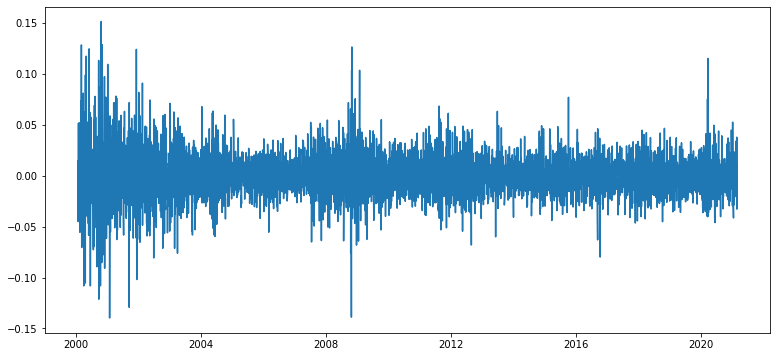

In [19]:
# 현재 시계열에서 한 스텝 앞으로 변화한 시계열을 빼준다.
# 이번 스텝에서 발생한 변화량 그래프(맞나?? 이부분 좀 헷갈림)
ts_log_moving_avg_diff = ts_log_moving_avg - ts_log_moving_avg_shift
ts_log_moving_avg_diff.dropna(inplace=True) #여기서 현재 스텝값-직전스텝값을 제거함(주기성 제거) 
plt.plot(ts_log_moving_avg_diff)

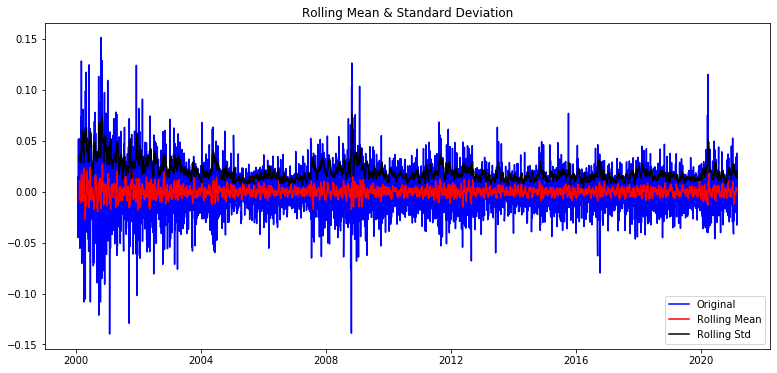

In [20]:
plot_rolling_statistics(ts_log_moving_avg_diff) 

In [21]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff)

Results of Dickey-Fuller Test:
Test Statistic                  -19.812448
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5274.000000
Critical Value (1%)              -3.431591
Critical Value (5%)              -2.862088
Critical Value (10%)             -2.567062
dtype: float64


1차 차분으로 p-value값이 확 줄었다. 현재 시계열 데이터는 안정적이다.

데이터에 따라서 여러번 차분을 하면서 p-value 값을 낮출 수 있다. 


## 3. 시계열 분해

statsmodels 라이브러리 안에 seasonal_decompose 메소드로 시계열 안에 존재하는 trend, seasonality를 직접 분리할 수 있다.

moving average 제거, differencing을 하지 않아도 안정적인 시계열을 만들 수 있다.

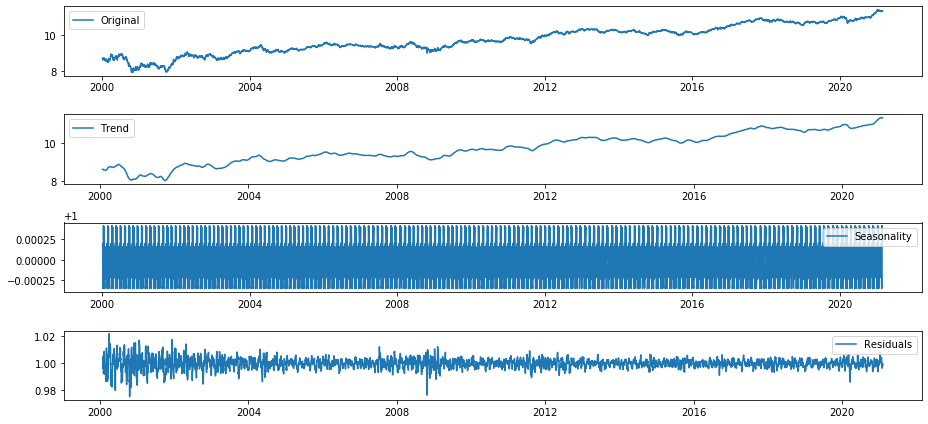

In [22]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

plt.tight_layout()

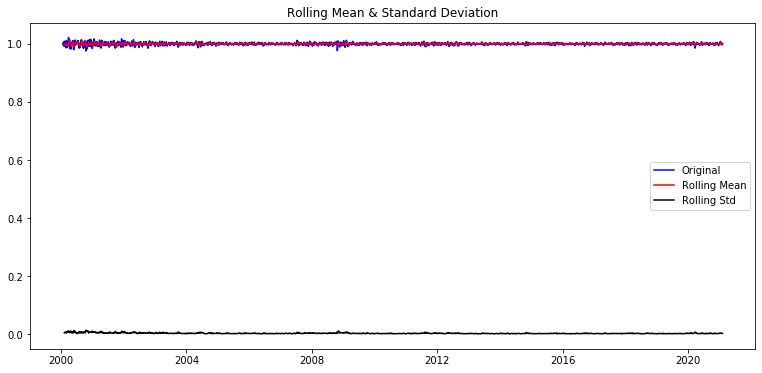

In [23]:
# residual 안정성 여부

plt.rcParams["figure.figsize"]=(13,6)
plot_rolling_statistics(residual)

In [24]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.760269e+01
p-value                        3.914322e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.256000e+03
Critical Value (1%)           -3.431595e+00
Critical Value (5%)           -2.862090e+00
Critical Value (10%)          -2.567063e+00
dtype: float64


residual의 p-value가 3...엄청나게 불안정한 시계열이다.

# ARIMA 모델(깔꿈하게 정리)

시계열 데이터 예측모델을 자동으로 만들어 주는 것

* AR(autoregressive)+I(integrated)+MA(moving average)

**시계열 데이터 Y={Yt:t∈T} Yt를 예측하기 위한 모델** 

**1. AR(자기회귀)**
* Yt가 이전 q개 데이터의 가중합으로 수렴한다고 보는 모델

* AR은 추세와 추기성을 제거한 잔차에 해당하는 부분을 모델링


특징


자기회귀 모델의 가중치의 크기가 1보다 작은 가중합일때 안정적인 시계열이다.

주식값이 항상 일정한 균형을 유지할거라고 전제하는 것이 AR 모델링의 관점이다. 

**2. I (차분누적, Integration)**

*  Yt이 이전 데이터와 d차 차분의 누적(integration) 합이라고 보는 모델입니다. 

* d=1이라면 Yt는 Yt−1과 ΔYt−1 의 합 (저 세모가 가중치?)

*  Seasonality에 해당하는 부분을 모델링


**3. MA(이동평균, Moving Average)**
* Yt가 이전 q개의 예측오차값 et−1,et−2,...,et−q 의 가중합으로 수렴한다고 보는 모델입니다. 

* MA는 일반적인 시계열에서 Trend에 해당하는 부분을 모델링


특징

예측한 오차값이 증가한 상태라면 예측보다 실제가 더 높았다는 뜻이므로 다음 예측할때 기대치를 올려서 잡는다. 

주식값은 항상 증가하고 떨어지는 패턴을 지속한다는 관점

# STEP 4 : 학습, 테스트 데이터셋 생성

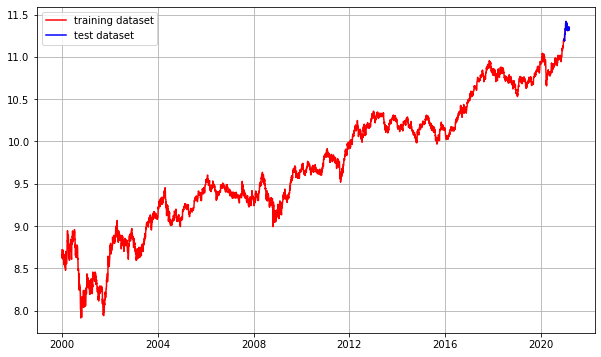

In [25]:
train_data, test_data = ts_log[:int(len(ts_log)*0.99)], ts_log[int(len(ts_log)*0.99):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [26]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2000-01-04    8.717682
2000-01-05    8.626944
Name: Close, dtype: float64
(5266,)
(54,)


# STEP 5 : 적정 ARIMA 모수 찾기

# ARIMA 모델의 모수 p, q, d
ARIMA를 활용해서 시계열 예측 모델을 성공적으로 만들기 위해서는 ARIMA의 모수(parameter)를 데이터에 맞게 설정해야 합니다

p:자기회귀 모형(AR)의 시차

q:차분(diffdrence) 횟수

d:이동평균 모형(MA)의 시차

* 모수 결정하는 방법
= p,d,q는 ACF(Autocorrelation Function)와 PACF(Partial Autocorrelation Function)을 통해 결정

**ACF**
= 시차(lag)에 따른 관측치들 사이의 관련성을 측정하는 함수

**PACF**
= 다른 관측치의 영향력을 배제하고 두 시차의 관측치 간 관련성을 측정하는 함

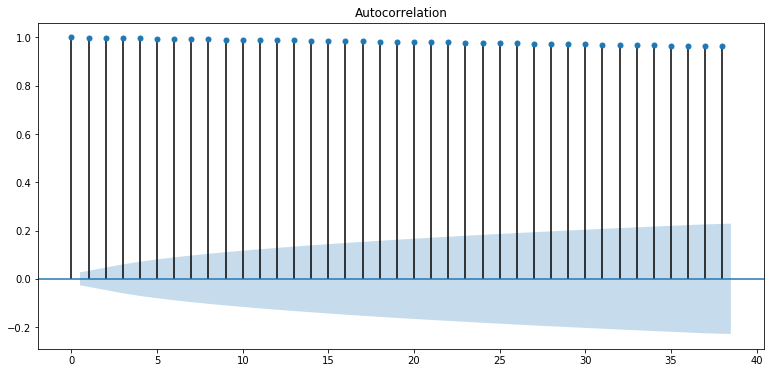

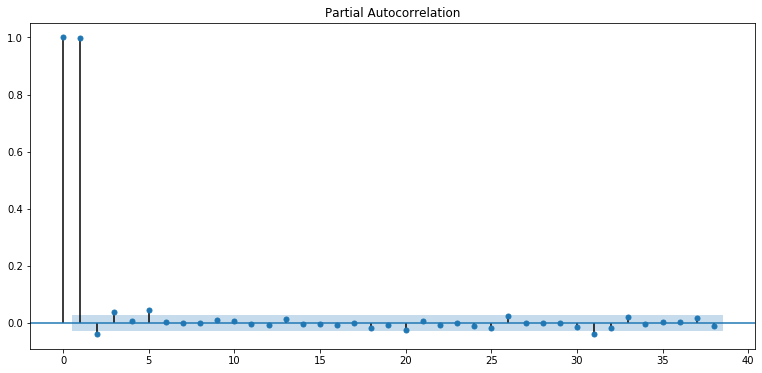

In [27]:
# ACF, PACF 그려보기 -> p,q 구하기
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF그래프 그리기(p)
plot_pacf(ts_log)  # PACF 그래프 그리기(q)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.107780
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


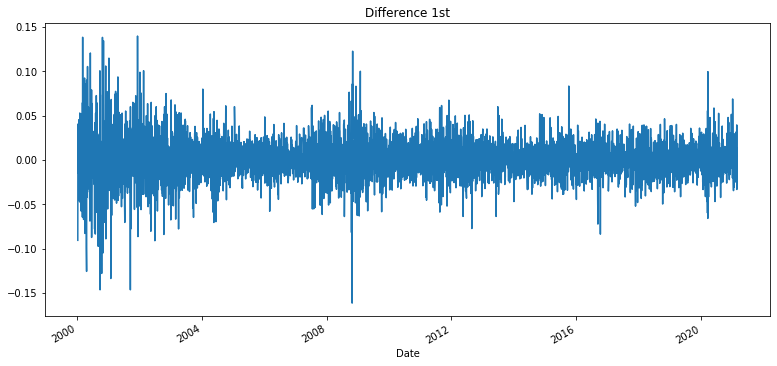

In [28]:
# 차분 안정성 확인 -> d 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# STEP 6 : ARIMA 모델 훈련과 테스트

    ARIMA 모델 빌드와 훈련
    모델 테스트 및 플로팅
    최종 예측 모델 정확도 측정(MAPE)


In [29]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(train_data, order=(2, 1, 1))  #p,d,q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

/home/aiffel-dj54/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj54/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5265
Model:                 ARIMA(2, 1, 1)   Log Likelihood               12523.050
Method:                       css-mle   S.D. of innovations              0.022
Date:                Thu, 04 Mar 2021   AIC                         -25036.099
Time:                        21:39:04   BIC                         -25003.255
Sample:                             1   HQIC                        -25024.618
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0005      0.000      1.799      0.072   -4.25e-05       0.001
ar.L1.D.Close     0.7236      0.079      9.206      0.000       0.570       0.878
ar.L2.D.Close    -0.0925      0.014     

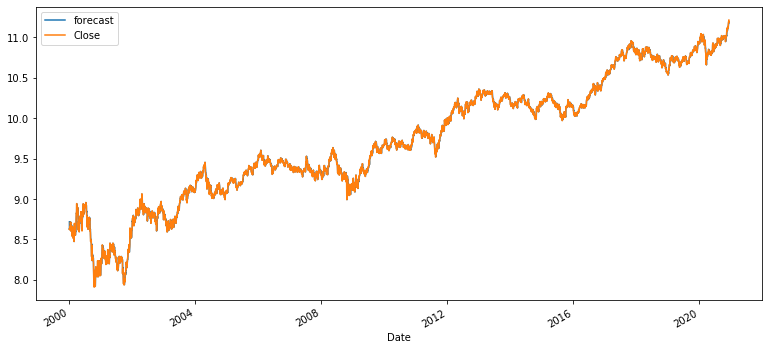

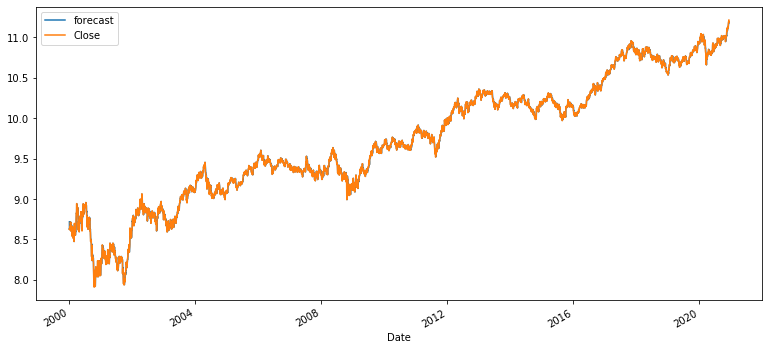

In [30]:
fitted_m.plot_predict()

forecast() 메소드를 이용해 테스트 데이터 구간의 데이터를 예측

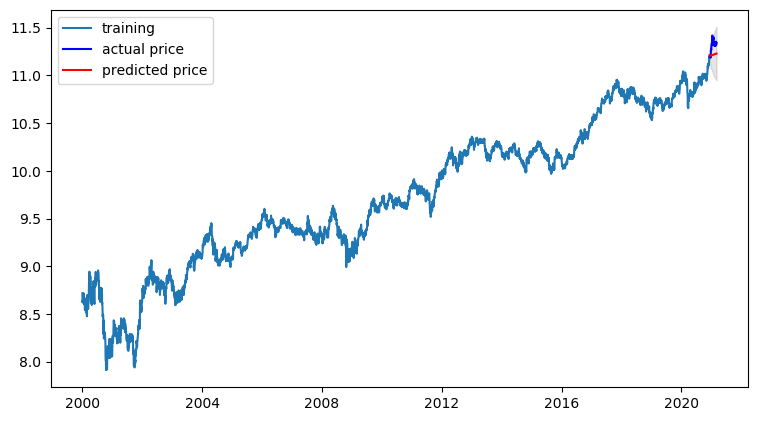

In [31]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(9,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

실제값과 예측값이 맞지 않는다. 모델의 오차율을 구하려면 로그변환한 시계열을 다시 지수변환한 후 계산해야한다. 

In [32]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
                         #지수변환
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)
#오차율
mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  87079424.86653648
MAE:  8099.642391173336
RMSE:  9331.635701555033
MAPE: 9.52%


오차율을 개선하고 싶다면 모수를 조절해서 개선할 수 있음 

p=20을 줘도 딱히 크게 오차율이 변하지 않음 

## try
1. p,d,q=(2, 1, 1) MAPE 20 test 비율 0.1

데이터를 MAX로 한 상태에서 TEST 데이터를 0.1%만 사용하게 되면 20년치를 보고 2년을 예측하게 된다. 정확도는 20% 내외를 머문다. 

TEST데이터의 범위를 (0.1->0.01) 최근을 보면 더 정확해진다. 

2. p,d,q= 2, 1, 1  MAPE 9.52%, test비율 0.01

train:(5266,) test:(54,)

# STEP 7 : 다른 주식 종목 예측해 보기



    관심 종목을 골라 위 STEP 1~6의 과정을 반복해 보기


# 구글 주식
* 데이터는 MAX로 사용! MAPE: 9.1%

# 1. 시계열 데이터 준비

In [33]:
dataset_filepath = os.getenv('HOME') + '/aiffel/aiffel_exp_data/stock_prediction/data/GOOGLE.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts1 = df['Close']

ts1.head()

Date
2004-08-19    49.982655
2004-08-20    53.952770
2004-08-23    54.495735
2004-08-24    52.239197
2004-08-25    52.802086
Name: Close, dtype: float64

In [34]:
#데이터 전처리
ts1=ts1.interpolate(method='time')
ts1[ts1.isna()] 

Series([], Name: Close, dtype: float64)

In [35]:
#로그 변환
ts1_log = np.log(ts1)

# 2. 시계열 안정성 분석

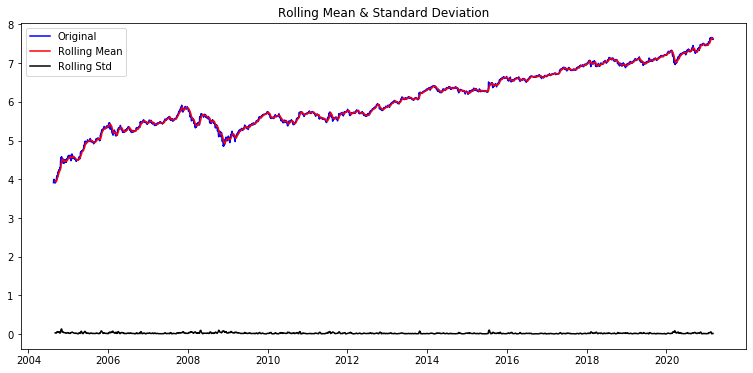

Results of Dickey-Fuller Test:
Test Statistic                   -1.895851
p-value                           0.334016
#Lags Used                        7.000000
Number of Observations Used    4155.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


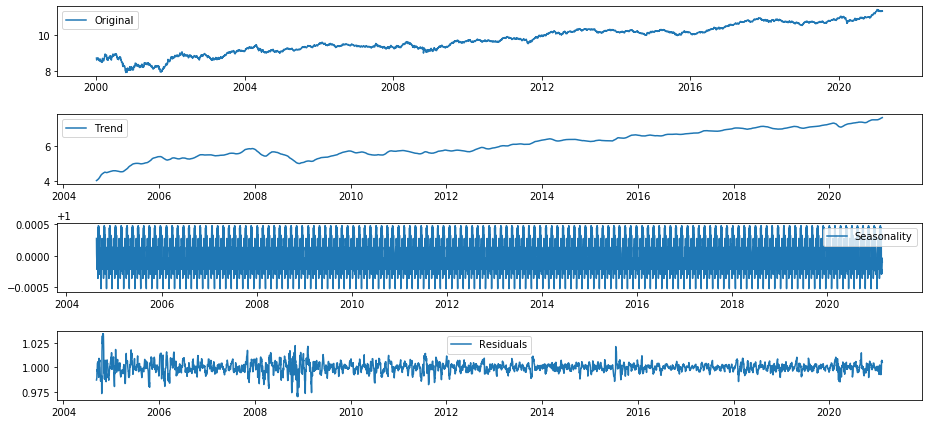

In [36]:
# 정성적 그래프 분석
plot_rolling_statistics(ts1_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [37]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.490784e+01
p-value                        1.473715e-27
#Lags Used                     3.000000e+01
Number of Observations Used    4.102000e+03
Critical Value (1%)           -3.431945e+00
Critical Value (5%)           -2.862245e+00
Critical Value (10%)          -2.567145e+00
dtype: float64


# 3. 학습, 테스트 데이터셋 생성

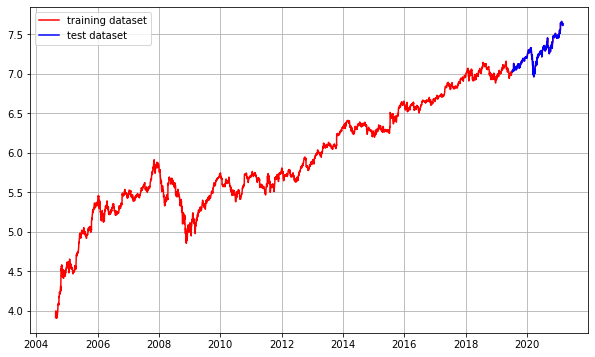

In [38]:
train_data, test_data = ts1_log[:int(len(ts1_log)*0.9)], ts1_log[int(len(ts1_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts1_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

# 4. 적정 ARIMA 모수 찾기

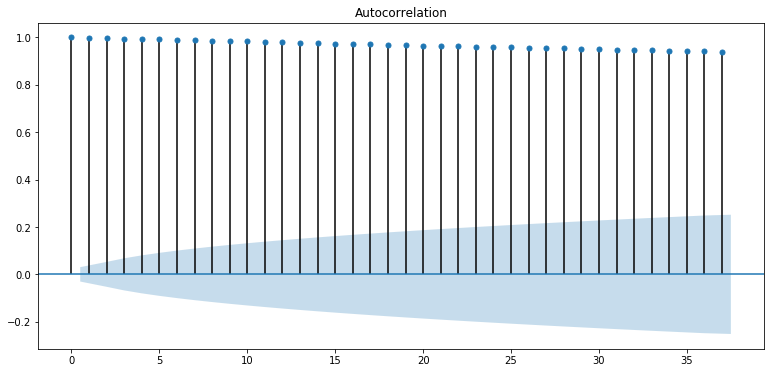

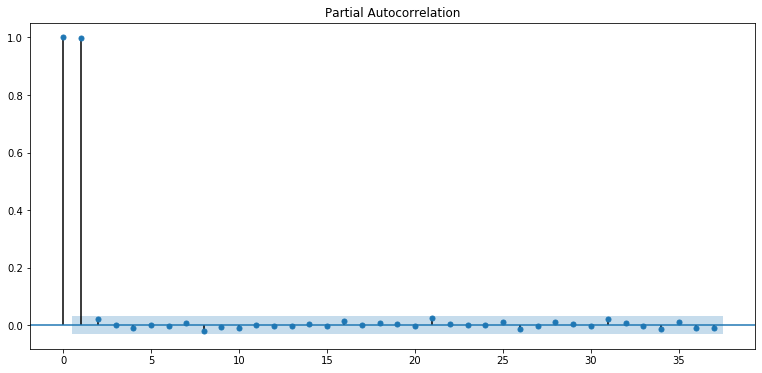

In [39]:
plot_acf(ts1_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts1_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -40.107780
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5315.000000
Critical Value (1%)              -3.431581
Critical Value (5%)              -2.862084
Critical Value (10%)             -2.567060
dtype: float64


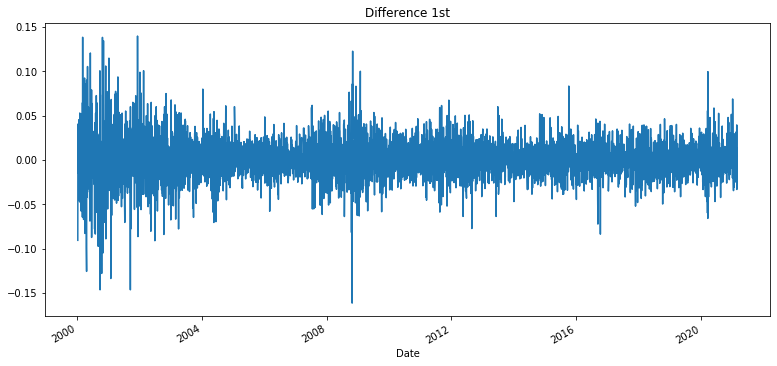

In [40]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 5. 모델 훈련과 테스트 

In [41]:
#모델훈련
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3745
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9551.347
Method:                       css-mle   S.D. of innovations              0.019
Date:                Thu, 04 Mar 2021   AIC                         -19096.693
Time:                        21:39:10   BIC                         -19078.009
Sample:                             1   HQIC                        -19090.048
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0008      0.000      2.659      0.008       0.000       0.001
ar.L1.D.Close     0.0107      0.016      0.655      0.512      -0.021       0.043
                                    Root

/home/aiffel-dj54/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj54/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


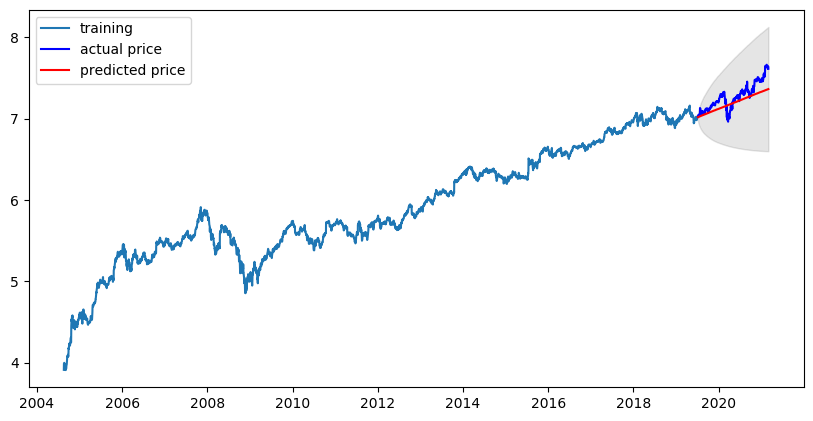

In [42]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()


In [43]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  34945.001030337364
MAE:  143.21445105690802
RMSE:  186.93582061856782
MAPE: 9.10%


구글 데이터는 test비율을 0.1로 해도 예측도가 높다 삼성데이터에 비해 큰 변화의 폭없이 상승해서 그런것 같다.

# 3. STARBUCKS 주식
1. 데이터를 MAX로 하면 코로나 상황에 따라 주식의 변화가 심해서 2020년을 제외하고 데이터를 뽑아봤다.
 * MAX로 했을때 MAPE: 20.96% 


2. 2004-2016 : 급변화가 없는 나름 안정적인 기간만 뽑아서 정확도를 예측해봤다.
 * MAPE: 7.42%

# 1. 데이터 불러오기

In [44]:
dataset_filepath = os.getenv('HOME') + '/aiffel/aiffel_exp_data/stock_prediction/data/starbucks(2004-2016).csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts2 = df['Close']

ts2.head(-1)

Date
2004-01-02     8.227500
2004-01-05     8.352500
2004-01-06     8.455000
2004-01-07     8.420000
2004-01-08     8.345000
                ...    
2016-12-22    57.110001
2016-12-23    57.009998
2016-12-27    56.860001
2016-12-28    56.349998
2016-12-29    56.320000
Name: Close, Length: 3272, dtype: float64

In [45]:
ts2=ts2.interpolate(method='time')
ts2[ts2.isna()] 

Series([], Name: Close, dtype: float64)

In [46]:
ts2_log = np.log(ts2)

# 2.시계열 안정성 분석

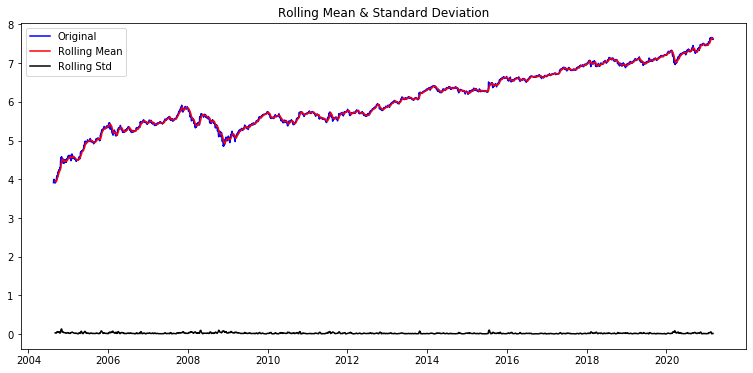

Results of Dickey-Fuller Test:
Test Statistic                   -1.895851
p-value                           0.334016
#Lags Used                        7.000000
Number of Observations Used    4155.000000
Critical Value (1%)              -3.431925
Critical Value (5%)              -2.862236
Critical Value (10%)             -2.567140
dtype: float64


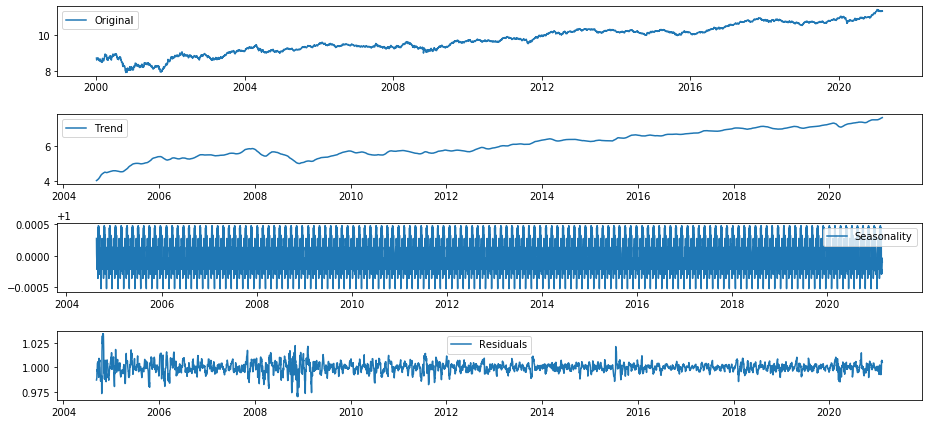

In [47]:
# 정성적 그래프 분석
plot_rolling_statistics(ts1_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts1_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [48]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.490784e+01
p-value                        1.473715e-27
#Lags Used                     3.000000e+01
Number of Observations Used    4.102000e+03
Critical Value (1%)           -3.431945e+00
Critical Value (5%)           -2.862245e+00
Critical Value (10%)          -2.567145e+00
dtype: float64


# 3. 학습, 테스트 데이터셋 생성

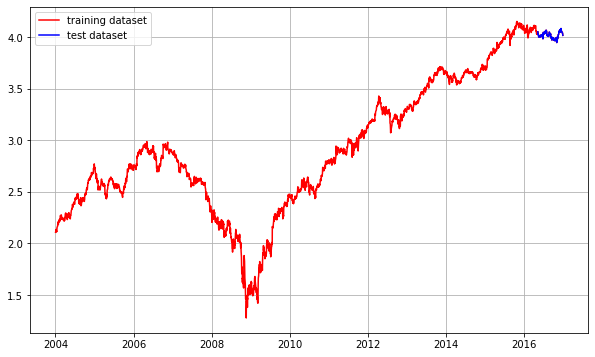

In [49]:
train_data, test_data = ts2_log[:int(len(ts2_log)*0.95)], ts2_log[int(len(ts2_log)*0.95):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts2_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [50]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2000-01-04    8.717682
2000-01-05    8.626944
Name: Close, dtype: float64
(3109,)
(164,)


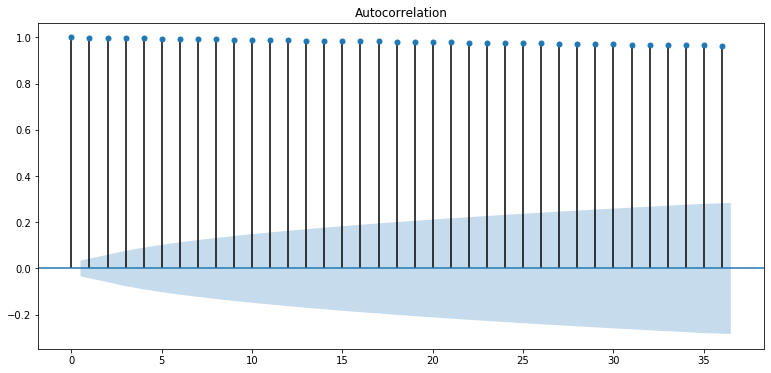

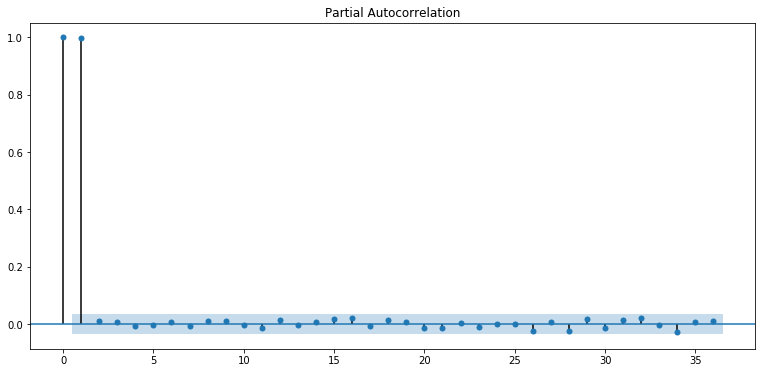

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts2_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts2_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -58.662748
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    3271.000000
Critical Value (1%)              -3.432351
Critical Value (5%)              -2.862424
Critical Value (10%)             -2.567241
dtype: float64


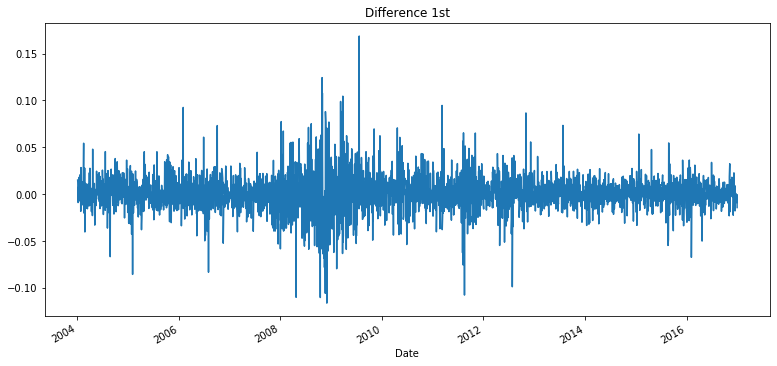

In [52]:
# 1차 차분 구하기
diff_1 = ts2_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

# 4. 모델 훈련과 테스트

In [53]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(8, 1, 1))  
# fitted_m = model.fit(trend='nc',full_output=True,disp=-1) 
fitted_m = model.fit(disp=-1) 
print(fitted_m.summary())

/home/aiffel-dj54/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel-dj54/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3108
Model:                 ARIMA(8, 1, 1)   Log Likelihood                7755.485
Method:                       css-mle   S.D. of innovations              0.020
Date:                Thu, 04 Mar 2021   AIC                         -15488.970
Time:                        21:39:14   BIC                         -15422.511
Sample:                             1   HQIC                        -15465.107
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0006      0.000      1.897      0.058   -2.06e-05       0.001
ar.L1.D.Close    -0.1157      0.475     -0.244      0.808      -1.047       0.815
ar.L2.D.Close    -0.0110      0.022     

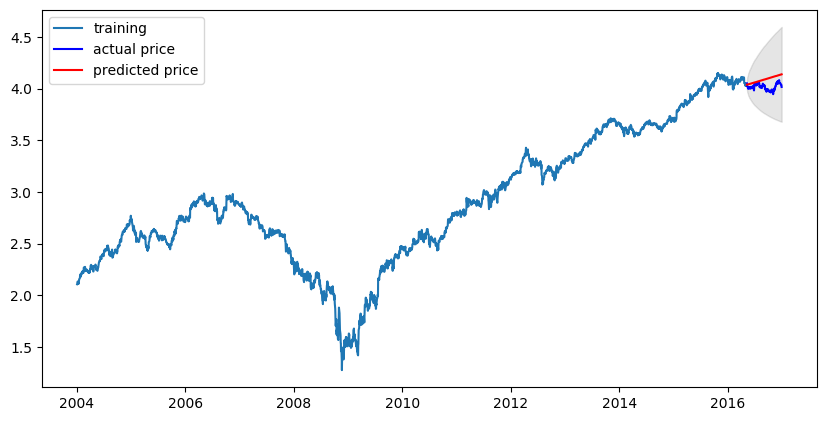

In [54]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [55]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))
#2004-2016 mape는 10.24

MSE:  22.093896693102828
MAE:  4.072577109355025
RMSE:  4.7004145235396875
MAPE: 7.42%


## 파라미터 수정
1. TRAIN 0.98/모수 2,1,1/ mape 2.61%
2. TRAIN 0.9/모수 2,1,1/ mape 11.73%
3. TRAIN 0.95/모수 8,1,1/ mape 7.42%

# 루브릭

1. 시계열의 안정성이 충분히 확인되었는가?
	플로팅과 adfuller 메소드가 모두 적절히 사용되었음


2. ARIMA 모델 모수선택 근거를 체계적으로 제시하였는가?
	p,q를 위한 ACF, PACF 사용과 d를 위한 차분 과정이 명확히 제시됨


3. 예측 모델의 오차율이 기준 이하로 정확하게 나왔는가?
	3개 이상 종목이 MAPE 10% 미만의 정확도로 예측됨
    

# 회고

1. 지금 만든 주식예측 프로그램이 실제로 사용할만큼 효과가 있을지는 모르겠지만 흐름을 알게 돼서 도움이 됐다.
2. 처음에 정확도가 안나와서 p,d,q를 수정해봤지만 큰 변화가 없었고 마지막에 테스트셋 비율을 바꾼게 정확도를 올리는데 영향을 미쳤다.

삼성 데이터를 MAX로 한 상태에서 TEST 데이터를 0.1%만 사용하게 되면 20년치를 보고 2년을 예측하게 된다. 정확도는 20% 내외를 머문다.
이때 TEST데이터의 범위를 (0.1->0.01)로 바꾸고 최근을 예측하면 더 정확해진다.

구글 데이터는 max로 데이터를 불러와도 정확도가 높았다.
삼성데이터보다 전반적으로 큰 변화의 폭이 없어서 20년치를 뽑아도 정확도가 높은것 같다.

스타벅스 데이터는 MAX로 했을때 정확도는 20%였고 파라미터를 수정해도 큰 변화는 없었다.
그래서 코로나 이전에 상승폭이 안정적이였던 기간 2004-2016으로 정확도를 예측해봤다.
이번에도 TEST데이터는 조금 사용했고 10미만의 오차가 나왔다.!
